In [3]:
!pip install opencv-python
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import math 
import cv2 
from glob import glob 
import itertools


from tensorflow.keras.utils import to_categorical  
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, CSVLogger

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix



scale = 70
seed = 7

  Using cached opencv_python-4.11.0.86-cp37-abi3-win_amd64.whl.metadata (20 kB)
Using cached opencv_python-4.11.0.86-cp37-abi3-win_amd64.whl (39.5 MB)


In [4]:
import numpy as np 
import pandas as pd 

import os
print(os.listdir("./train/"))

['Black-grass', 'Charlock', 'Cleavers', 'Common Chickweed', 'Common wheat', 'Fat Hen', 'Loose Silky-bent', 'Maize', 'Scentless Mayweed', 'Shepherds Purse', 'Small-flowered Cranesbill', 'Sugar beet']


In [5]:
path_to_images = './train/*/*.png'
images = glob(path_to_images)
trainingset = []
traininglabels = []
num = len(images)
count = 1

for i in images:
    print(str(count)+'/'+str(num),end='\r')
    trainingset.append(cv2.resize(cv2.imread(i),(scale,scale)))
    traininglabels.append(i.split('/')[-2])
    count=count+1
trainingset = np.asarray(trainingset)
traininglabels = pd.DataFrame(traininglabels)

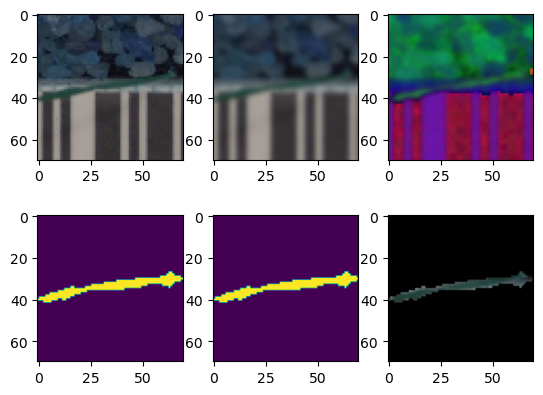

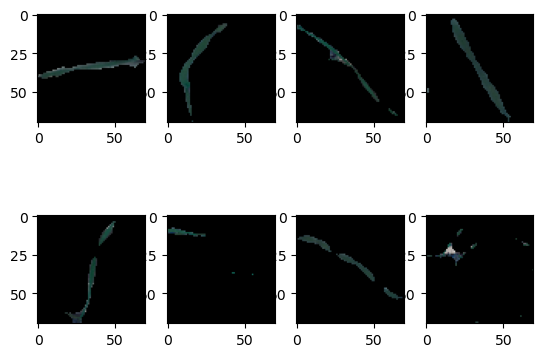

In [ ]:
new_train = []
sets = []
getEx = True
for i in trainingset:
    blurr = cv2.GaussianBlur(i,(5,5),0)
    hsv = cv2.cvtColor(blurr,cv2.COLOR_BGR2HSV)
    
    lower = (25,40,50)
    upper = (75,255,255)
    mask = cv2.inRange(hsv,lower,upper)
    struc = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(11,11))
    mask = cv2.morphologyEx(mask,cv2.MORPH_CLOSE,struc)
    boolean = mask>0
    new = np.zeros_like(i,np.uint8)
    new[boolean] = i[boolean]
    new_train.append(new)
    
    if getEx:
        plt.subplot(2,3,1);plt.imshow(i) 
        plt.subplot(2,3,2);plt.imshow(blurr) 
        plt.subplot(2,3,3);plt.imshow(hsv) 
        plt.subplot(2,3,4);plt.imshow(mask) 
        plt.subplot(2,3,5);plt.imshow(boolean) 
        plt.subplot(2,3,6);plt.imshow(new) 
        plt.show()
        getEx = False
new_train = np.asarray(new_train)


for i in range(8):
    plt.subplot(2,4,i+1)
    plt.imshow(new_train[i])

Classes: ['Black-grass', 'Charlock', 'Cleavers', 'Common Chickweed', 'Common wheat', 'Fat Hen', 'Loose Silky-bent', 'Maize', 'Scentless Mayweed', 'Shepherds Purse', 'Small-flowered Cranesbill', 'Sugar beet']
Number of classes: 12
        filename        label
0  0050f38b3.png  Black-grass
1  0183fdf68.png  Black-grass
2  0260cffa8.png  Black-grass
3  05eedce4d.png  Black-grass
4  075d004bc.png  Black-grass
Classes: ['Black-grass' 'Charlock' 'Cleavers' 'Common Chickweed' 'Common wheat'
 'Fat Hen' 'Loose Silky-bent' 'Maize' 'Scentless Mayweed'
 'Shepherds Purse' 'Small-flowered Cranesbill' 'Sugar beet']
Number of classes: 12


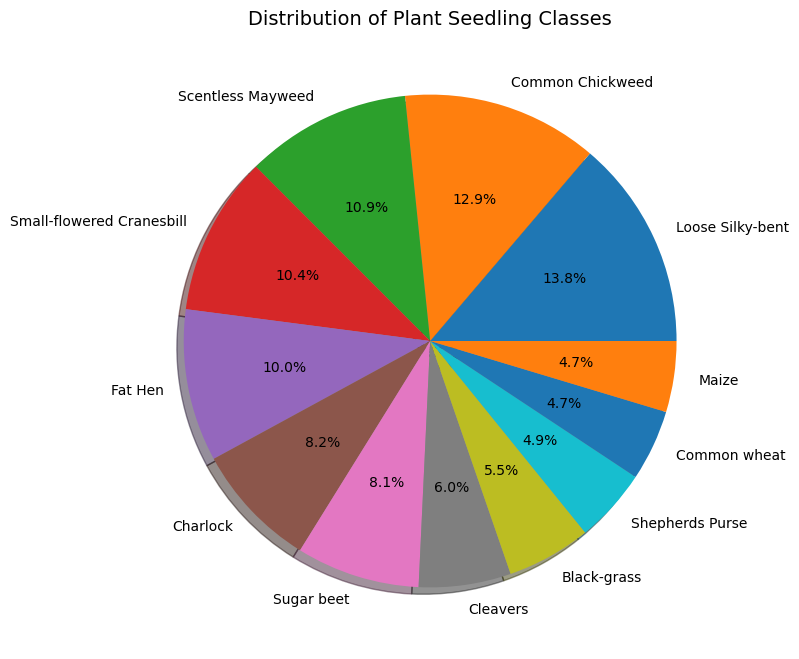

In [ ]:
import os
import pandas as pd
from tensorflow.keras.utils import to_categorical
from sklearn import preprocessing
import matplotlib.pyplot as plt


train_dir = "./train/"


classes = os.listdir(train_dir)
print(f"Classes: {classes}")
print(f"Number of classes: {len(classes)}")


data = []
for class_name in classes:
    class_path = os.path.join(train_dir, class_name)
    if os.path.isdir(class_path):  
        for file in os.listdir(class_path):
            data.append([file, class_name])  


traininglabels = pd.DataFrame(data, columns=["filename", "label"])
print(traininglabels.head())


labels = preprocessing.LabelEncoder()
labels.fit(traininglabels["label"])  
print('Classes: ' + str(labels.classes_))


encodedlabels = labels.transform(traininglabels["label"])
clearalllabels = to_categorical(encodedlabels)
classes = clearalllabels.shape[1]
print(f"Number of classes: {classes}")


traininglabels["label"].value_counts().plot(kind='pie', figsize=(8, 8), autopct='%1.1f%%', shadow=True)
plt.title('Distribution of Plant Seedling Classes', fontsize=14)
plt.ylabel('')
plt.show()

In [ ]:

new_train = new_train/255
x_train,x_test,y_train,y_test = train_test_split(new_train,clearalllabels,test_size=0.1,random_state=seed,stratify=clearalllabels)

In [ ]:
#Data Augmentation
generator = ImageDataGenerator(rotation_range = 180,zoom_range = 0.1,width_shift_range = 0.1,height_shift_range = 0.1,horizontal_flip = True,vertical_flip = True)
generator.fit(x_train)

In [ ]:
np.random.seed(seed)

model = Sequential()

model.add(Conv2D(filters=64, kernel_size=(5, 5), input_shape=(scale, scale, 3), activation='relu'))
model.add(BatchNormalization(axis=3))
model.add(Conv2D(filters=64, kernel_size=(5, 5), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(BatchNormalization(axis=3))
model.add(Dropout(0.1))

model.add(Conv2D(filters=128, kernel_size=(5, 5), activation='relu'))
model.add(BatchNormalization(axis=3))
model.add(Conv2D(filters=128, kernel_size=(5, 5), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(BatchNormalization(axis=3))
model.add(Dropout(0.1))

model.add(Conv2D(filters=256, kernel_size=(5, 5), activation='relu'))
model.add(BatchNormalization(axis=3))
model.add(Conv2D(filters=256, kernel_size=(5, 5), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(BatchNormalization(axis=3))
model.add(Dropout(0.1))

model.add(Flatten())# 2D feature maps to 1d vector

model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5)) #prevent overfitting

model.add(Dense(classes, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy']) #loss function is categorical_crossentropy

model.summary()

c:\Users\jashu\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 66, 66, 64)     │         4,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 66, 66, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 62, 62, 64)     │       102,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 31, 31, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 31, 31, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 31, 31, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 27, 27, 128)    │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 27, 27, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 23, 23, 128)    │       409,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 11, 11, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 11, 11, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 11, 11, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 7, 7, 256)      │       819,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 7, 7, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 3, 3, 256)      │     1,638,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 1, 1, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 1, 1, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 1, 1, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 3,320,396 (12.67 MB)

 Trainable params: 3,317,580 (12.66 MB)

 Non-trainable params: 2,816 (11.00 KB)

(4275, 70, 70, 3) (4275, 12)
(475, 70, 70, 3) (475, 12)
Epoch 1/5
134/134 ━━━━━━━━━━━━━━━━━━━━ 123s 832ms/step - accuracy: 0.2401 - loss: 2.8166
Epoch 2/5
134/134 ━━━━━━━━━━━━━━━━━━━━ 117s 869ms/step - accuracy: 0.3966 - loss: 1.8427
Epoch 3/5
134/134 ━━━━━━━━━━━━━━━━━━━━ 109s 815ms/step - accuracy: 0.4851 - loss: 1.5358
Epoch 4/5
134/134 ━━━━━━━━━━━━━━━━━━━━ 119s 887ms/step - accuracy: 0.5643 - loss: 1.2783
Epoch 5/5
134/134 ━━━━━━━━━━━━━━━━━━━━ 119s 888ms/step - accuracy: 0.6295 - loss: 1.1003


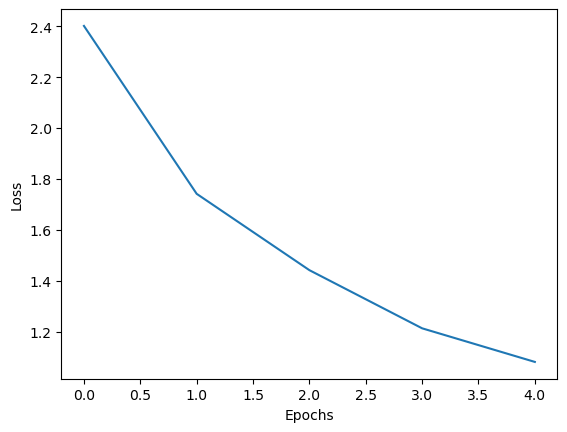

15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 222ms/step - accuracy: 0.6450 - loss: 1.0973
Test Loss: 1.1711715459823608
Test Accuracy: 0.6126315593719482


In [ ]:
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)
history = model.fit(x_train, y_train, epochs=5)

plt.plot(history.history['loss'])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()


test_loss, test_accuracy = model.evaluate(x_test, y_test)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

In [12]:
pred_labels = model.predict(x_test)
print(pred_labels.shape)
acc = model.evaluate(x_test, y_test)
print("Testing accuracy : {}".format(acc[-1] * 100))

15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 257ms/step
(475, 12)
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 221ms/step - accuracy: 0.6450 - loss: 1.0973
Testing accuracy : 61.263155937194824


15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 230ms/step
[1.22179635e-01 7.16439821e-03 6.26660092e-03 3.24579305e-04
 5.49438477e-01 6.48658955e-04 3.00177366e-01 7.68046302e-04
 1.20959487e-02 3.28694587e-04 1.43960075e-04 4.63689008e-04]
4
Predicted label : Common wheat


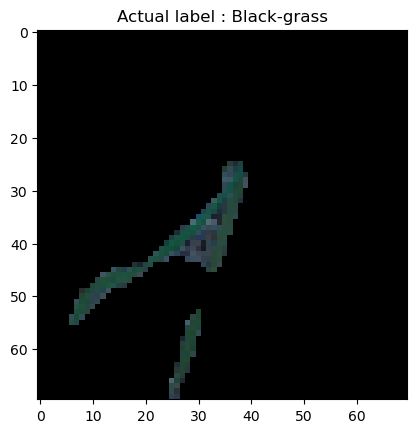

15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 211ms/step
[0.00255262 0.06693324 0.02900177 0.00327792 0.00307166 0.00594423
 0.00479143 0.01916805 0.81020546 0.031246   0.0069549  0.01685274]
8
Predicted label : Scentless Mayweed


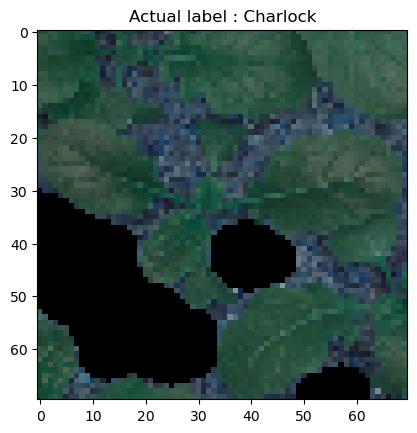

15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 227ms/step
[0.0022019  0.10462433 0.0157804  0.00430126 0.00091802 0.00160731
 0.00179567 0.10112713 0.7168193  0.03562348 0.00888307 0.00631818]
8
Predicted label : Scentless Mayweed


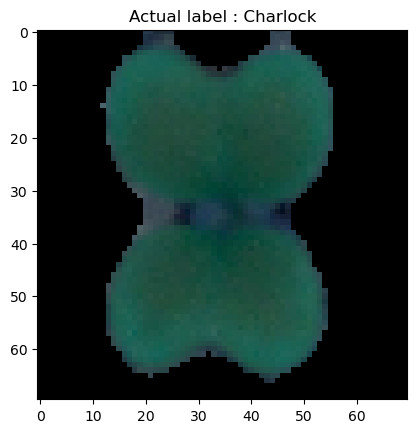

15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 214ms/step
[3.2801916e-05 1.4891320e-02 4.5686834e-03 4.2769671e-04 8.3121638e-05
 1.3511593e-03 8.4560685e-05 1.4439214e-03 3.6321837e-04 1.4329442e-02
 9.6160907e-01 8.1496750e-04]
10
Predicted label : Small-flowered Cranesbill


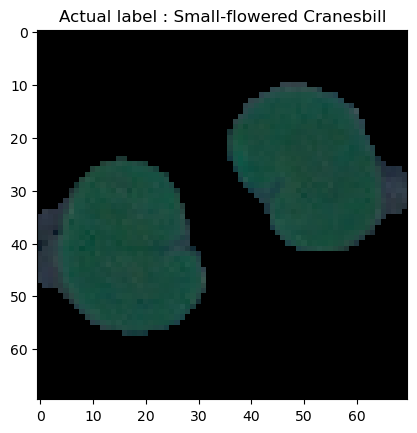

15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 219ms/step
[8.4097746e-07 5.3669294e-07 1.6336234e-06 9.9889708e-01 2.6048208e-06
 4.2427194e-04 5.3524055e-08 6.5083019e-05 4.6785194e-06 6.0220057e-04
 5.5221750e-07 3.1018399e-07]
3
Predicted label : Common Chickweed


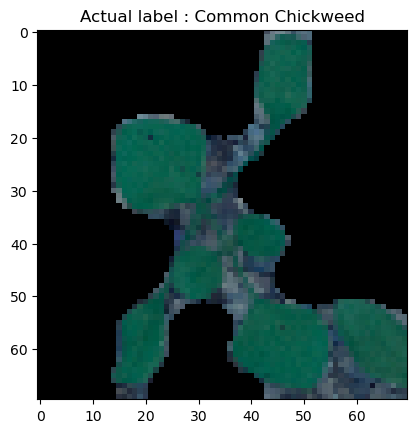

images saved successfully!


In [ ]:
from keras.preprocessing.image import save_img
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import load_img
import numpy as np
import matplotlib.pyplot as plt


num_images = 5
idxs = np.random.choice(len(x_test), num_images, replace=False)

for idx in idxs:
    pred_label = model.predict(x_test)
    print(pred_label[idx])
    print(np.argmax(pred_label[idx], axis=0))
    print("Predicted label : " + str(labels.classes_[np.argmax(pred_label[idx], axis=0)]))

    plt.imshow(x_test[idx])
    plt.title("Actual label : " + str(labels.classes_[np.argmax(y_test[idx], axis=0)]))
    plt.show()

    img = x_test[idx]
    img_array = img_to_array(img)
 
    save_img(f"test_{idx}.png", img_array)

print("images saved successfully!")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


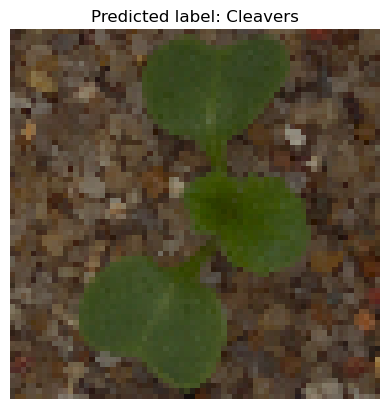

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


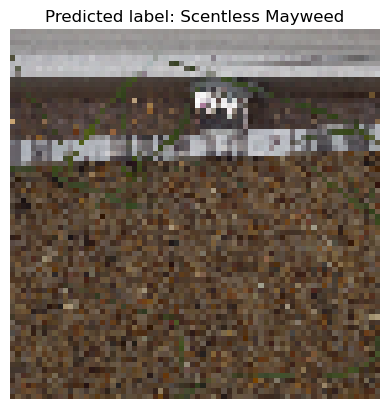

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


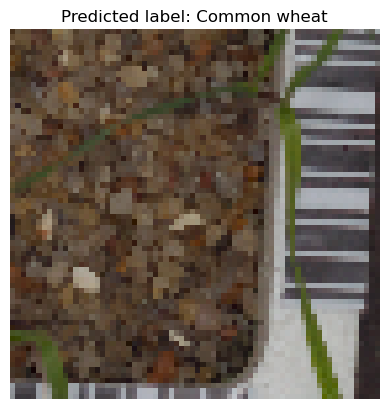

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


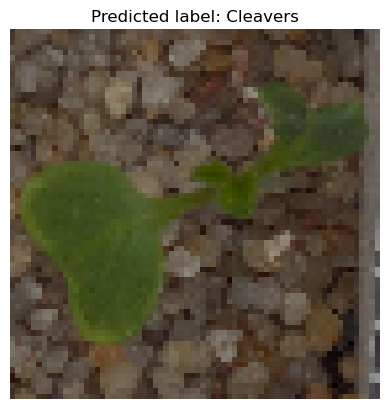

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step


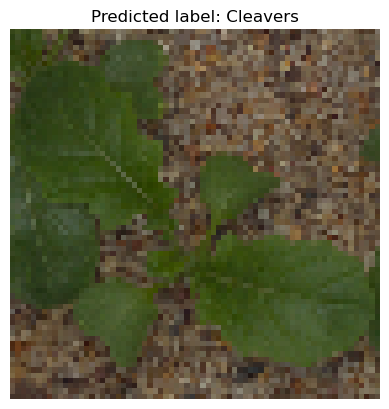

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


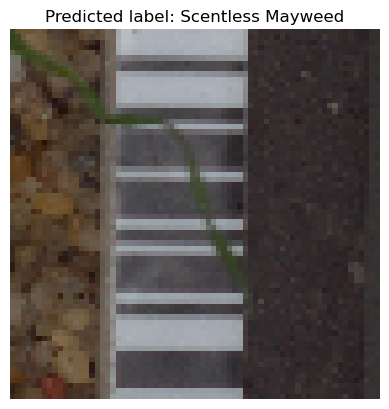

Predictions completed!


In [ ]:
from keras.preprocessing.image import save_img, img_to_array, load_img
import numpy as np
import matplotlib.pyplot as plt
import os


custom_folder = "C:\\Users\\jashu\\Desktop\\KLU YEAR 2\\PROJECTS\\DL custom test"

image_files = [f for f in os.listdir(custom_folder) if f.endswith(('.png', '.jpg', '.jpeg'))]


for image_file in image_files:
   
    img_path = os.path.join(custom_folder, image_file)
    img = load_img(img_path, target_size=(scale, scale))  
    img_array = img_to_array(img)  
    img_array = img_array / 255.0  
    img_array = np.expand_dims(img_array, axis=0) 

    
    pred_label = model.predict(img_array)
    predicted_class = np.argmax(pred_label, axis=1)[0] 
    predicted_label = labels.classes_[predicted_class]  
    
    plt.imshow(img)
    plt.title(f"Predicted label: {predicted_label}")
    plt.axis('off')
    plt.show()

    
    save_img(f"predicted_{image_file}", img_to_array(img))

print("Predictions completed!")